# RIS analysis using Hyperspy

## Access data

In [16]:
#-----USER INPUTS-----
#name of file
filename='ROI2_450kx_SS5_CA50_onedge.bcf'
#filename='ROI1_450kx_SS5_CA50_onedge.bcf'
#filename='Bruker.bcf'

#location of file
path='C:\\Users\Gabriella\Documents\EDS_data'

#name of excel file
mat_comp='Fe9Cr_elem_data.xlsx'
#mat_comp='HT9_elem_data_rev1.xlsx'
#mat_comp='HT9_elem_data.xlsx'


#-----IMPORTS-----
#imports hyperspy
import hyperspy.api as hs
#imports os module
import os
#import excel reading module
import xlrd
#import numpy
import numpy as np
#import curve fitter
from astropy import modeling
#import plotting tool
import matplotlib.pyplot as plt

#-----CONFIRM FILE AND PATH-----
#if the file path exists
if os.path.exists(path)==True:
    #change working directory to indicated path
    os.chdir(path)
    #tell user what the current path is after statements
    print('Working directory: ',os.getcwd())
    
#if the path does not exist
else:
    #tell user that path does not exist
    print('Path does not exist.')
    
#if the file exists in location
if os.path.isfile(filename):
    #confirm file exists
    print ('Filename: ',filename)
    
#if the file does not exist
else:
    #tell user file does not exist
    print('File does not exist.')

Working directory:  C:\Users\Gabriella\Documents\EDS_data
Filename:  ROI2_450kx_SS5_CA50_onedge.bcf


## Load data

In [17]:
#import data
data=hs.load(filename)

#determine type of file
end=filename[-3:]

#bruker file
if end=='bcf':
    #look at each item in data
    for j in range(len(data)):
        #check for EDS data indicator
        if 'EDS_TEM' in data[j].metadata:
            #stop loop once found
            break
    #indicate data of interest
    data=data[j]

#velox file
elif end=='emi':
    print('This script is not made for velox files currently.')

## Quantify data

In [18]:
#window width
iw=data.estimate_integration_windows(windows_width=5)

#open workbook with elemental information
#workbook=xlrd.open_workbook('HT9_elem_data.xlsx')
#workbook=xlrd.open_workbook('HT9_elem_data_rev1.xlsx')
workbook=xlrd.open_workbook(mat_comp)

#open sheet with elemental information
sheet=workbook.sheet_by_name('elements')

#put data from workbook in list
elem=[sheet.row_values(rowx) for rowx in range(sheet.nrows)]

#list of elements
elements=[]
[elements.append(elem[i][0]) for i in range(1,len(elem))]

#set elements of interest
data.set_elements(elements)

#list of desired x-ray lines
lines=[]
#cycle through list of elements
for i in elements:
    #create string for K alpha x-ray line
    string1=i+'_Ka'
    #append x-ray line to list
    lines.append(string1)

#set x-ray lines of interest
data.set_lines(lines)

#list of atom %
atw=[]
[atw.append(elem[i][4]) for i in range(1,len(elem))]

#get intensities of each line identified in metadata
intensities=data.get_lines_intensity(integration_windows=iw)
print(intensities)

#get list of sum of intensities for each element at edge of data
total_int=[]
[total_int.append(sum(i.sum(0).data[1:200])) for i in intensities]

#base element index for cliff-lorimer
base_ind=total_int.index(max(total_int))

#display base element used
print('base element:',elements[base_ind])

#next base element in a set
new_totals=set(total_int)

#list of totals with first base element removed
new_totals.remove(max(total_int))

#index of next base element
next_ind=total_int.index(max(new_totals))

#display next base element used
print('next base element:',elements[next_ind])

#empty list of kfactors
kfactors=[]
#calculate for each element considering 2 lists
for i,j in zip(atw,total_int):
    #for elements that are not the base element
    if atw.index(i)!=base_ind:
        #calculate kfactor
        kfactors.append((i/atw[base_ind])*(total_int[base_ind]/j))
    #for element that is the base element
    elif atw.index(i)==base_ind:
        #calculate kfactor
        kfactors.append((i/atw[next_ind])*(total_int[next_ind]/j))
        
#show kfactors
[print(elements[i],':',kfactors[i]) for i in range(len(elements))]

#convert to atomic percent
quant=data.quantification(intensities,'CL',factors=kfactors,composition_units='atomic')

#plot base element atomic percent map
#quant[base_ind].plot()

#plot next base element atomic percent map
#quant[next_ind].plot()

#plot all atomic percent maps
#hs.plot.plot_images(quant, cmap='viridis', axes_decor=None, scalebar='all')

[<BaseSignal, title: X-ray line intensity of EDX: C_Ka at 0.28 keV, dimensions: (1024, 1024|)>, <BaseSignal, title: X-ray line intensity of EDX: Cr_Ka at 5.41 keV, dimensions: (1024, 1024|)>, <BaseSignal, title: X-ray line intensity of EDX: Fe_Ka at 6.40 keV, dimensions: (1024, 1024|)>]
base element: Fe
next base element: C
C : 0.0009380937794945506
Cr : 0.5900722529410164
Fe : 1065.9915051763853


IndexError: list index out of range

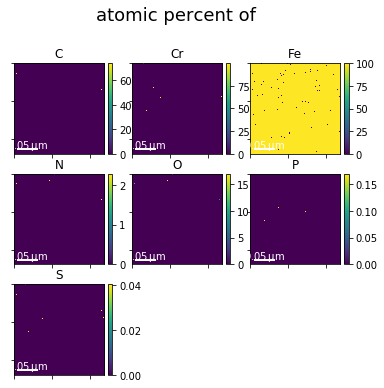

In [15]:
#plot all atomic percent maps
hs.plot.plot_images(quant, cmap='viridis', axes_decor=None, scalebar='all')

## Determine grain boundary

In [14]:
#get data of base element (majority elemental composition of alloy)
base=quant[base_ind].data

#get list of lists with base element averages along each row
aves=[]
[[aves.append(sum(base[j][i-20:i+20])/40) for i in range(len(base[1]))] for j in range(len(base))]

#reshape the averages to match dimensions
aves=np.reshape(aves,(1024, 1024))

#get minimum value of each row towards the center
min_val=[]
[min_val.append(min(i[200:900])) for i in aves]
#print(min_val)

#empty list of grain boundary ranges for each row
boundary_range=[]
#empty list of grain boundary final indices for each row
boundary_ind=[]
#each row in the matrix with averages
for i in range(1024):
    #starting range
    r=0
    #empty list of ranges within each row
    ranges=[]
    #empty list of final indices within each row
    fin_ind=[]
    
    #each element in row
    for j in range(200,901):
        #averages less than 110% of absolute minimum average
        #if aves[i][j]<=(1.1*min(min_val)):
        if aves[i][j]<=(1.2*(min_val[i]+1)):
            #increase range by 1
            r+=1
        #averages greater than 110% of absolute minimum average
        #elif aves[i][j]>(1.1*min(min_val)):
        elif aves[i][j]>(1.2*(min_val[i]+1)):
            #append range to list
            ranges.append(r)
            #append final index to list
            fin_ind.append(j)
            #reset range
            r=0
    #print(i)        
    #print(ranges)
    #print(fin_ind)
    
    #no range
    if ranges==[]:
        #range is 0
        boundary_range.append(0)
        #minimum of row of averages
        boundary_ind.append(np.argmin(aves[i][200:900]))
    #ranges exist
    elif max(ranges)!=[]:
        #largest range for each row
        boundary_range.append(max(ranges))
        #index associated with largest range for each row
        boundary_ind.append(fin_ind[ranges.index(max(ranges))])

#display ranges of grain boundary for each row
#print(boundary_range)

#display final indices of grain boundary for each row
#print(boundary_ind)

#comparing 2 ranges at a time
for i in range(len(boundary_range)-1):
    #first set of indices in a range
    set1=set(list(range(boundary_ind[i]-boundary_range[i],boundary_ind[i])))
    #second set of indices in a range
    set2=set(list(range(boundary_ind[i+1]-boundary_range[i+1],boundary_ind[i+1])))
    #intersection of elements between sets
    common=set1.intersection(set2)
    #empty set
    if common==set():
        #grain boundary not connected
        print('This grain boundary is NOT defined.')
        #end loop
        break

This grain boundary is NOT defined.


## Fit Gaussian

In [ ]:
#Ni or Cr should be used to fit the Gaussian
#Cr=intensities[1].data
Cr_ind=elements.index('Cr' or 'cr' or 'chromium' or 'Chromium' or 'CHROMIUM')
Cr=quant[Cr_ind].data
#m=data[1].create_model()
#m.components
#m.plot(plot_components=True)
#m.fit_component('Fe_Ka')
#line=hs.model.components.Gaussian()
#m.append(line)
#m.fit(fitter="mpfit", bounded=True)
#row of data
line=500
#half of width of area of interest
width=512
#x data
x=np.linspace(min_ind[line]-width,min_ind[line]+width,2*width)
#y data
y=Cr[line][min_ind[line]-width:min_ind[line]+width]
#fitting function
fitter=modeling.fitting.LevMarLSQFitter()
model=modeling.models.Gaussian1D(max(y),mean=Cr[line][min_ind[line]])
fitted_model=fitter(model,x,y)
#plot to check accuracy
plt.plot(x, y,label='data')
plt.plot(x, fitted_model(x),label='fit')
plt.legend()
fitted_model

## Calculate peak intensity

In [ ]:
#use built in max function
max(y)

## Calculate integral intensity

In [ ]:
#use built in integral function
#Cr.integrate1D(1).data
sum(y)

In [ ]:
#extra lines to DELETE later
#filename='20191115 0749 SI EDS-HAADF-BF Nano Diffraction 588.6 kx.emd'
#filename='ROI1_450kx_SS5_CA50_0001_4.ser'
#filename='ROI_lg_0001.emi'
#filename='20191113_1216_SI_EDS_HAADF_Nano_Diffraction_416_2_kx.emd'
#filename='09_52_08_Scanning_Acquire_0003.emi'


#look at integration windows with eds spectrum
#data.plot(integration_windows=iw)

#add tungsten
#data.add_elements(['W'])
#data.add_lines(['W_La'])

#data.plot(True)

#print(data.metadata.Sample)
#print(intensities)

#print(elements[total_int.index(max(total_int))])

#cascade_plot = hs.plot.plot_spectra(Fe, style='cascade')

#use to look at data or apply functions not within hyperspy
##Fe_data=np.exp(Fe).data
#get list of indices where minimum occurs in each row
#min_ind=Fe.indexmin(axis=1).data

#min_ind=[]
#[min_ind.append(np.where(i[200:900]==j)) for (i,j) in zip(aves,min_val)]
#print(min_ind)

    #for j in range(len(min_ind[i])-1):
    #    if min_ind[i][j]+1==mind_ind[i][j+1]:
    #        r+=1
    #    elif min_ind[i][j]+1!=mind_ind[i][j+1]:
    #        ranges.append(r)
    #        fin_ind.append(min_ind[i][j])
    #        r=0
    
#empty set of unions
#connect=[]